### Prepared by Nikita Aksenov, Stepan Svirin and Maxim Voronin
### Implementation of paper "Simple and Scalable Predictive Uncertainty Estimation using Deep Ensembles" (https://arxiv.org/abs/1612.01474)

# Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os

# Loading Data

## Getting MNIST dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])


training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)


training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)


classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')


print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 9912422/9912422 [00:00<00:00, 112845312.27it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33979156.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40018119.52it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4281017.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


2  4  2  5  3  0  1  7  5  6  8  7  5  2  5  8


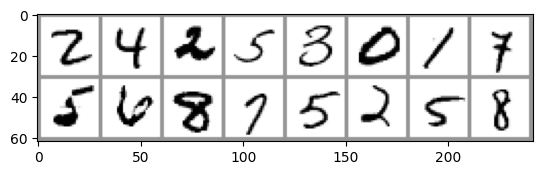

In [ ]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)


img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(16)))

## Getting notMNIST

#### You can get notMNIST in github. Just upload it to your google drive root directory and mount the drive as in the first cell of the notebook

In [ ]:
!unzip -qq -d /content/data /content/drive/MyDrive/notMNIST_small.zip #unzip the file

In [ ]:
data_dir = '/content/data/notMNIST_small'


transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

num_samples = len(dataset)
train_size = int(0.8 * num_samples)
val_size = num_samples - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

num_classes = len(dataset.classes)
class_names = dataset.classes
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 10
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']


E  E  F  E  A  E  D  F  B  B  G  D  J  F  A  G


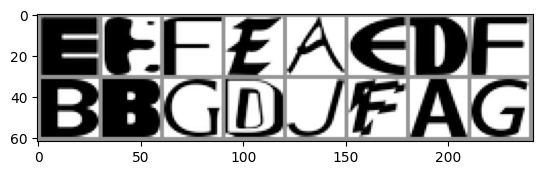

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(class_names[labels[j]] for j in range(16)))

In [ ]:
set1 = torch.utils.data.Subset(validation_set, [i for i in range(160)])
set2 = torch.utils.data.Subset(dataset, [i for i in range(160)])
load1 = torch.utils.data.DataLoader(set1, batch_size=16, shuffle=False)
load2 = torch.utils.data.DataLoader(set2, batch_size=16, shuffle=False)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Auxillary functions

In [ ]:
def train_one_epoch(epoch_index, tb_writer, model=None, optimizer=None):
    running_loss = 0.
    last_loss = 0.
    for i, data in enumerate(training_loader):
        inputs, labels = data
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
def train_one_epoch_adv(epoch_index, tb_writer, model=None, optimizer=None):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data
        labels.to(device)
        optimizer.zero_grad()

        inputs.requires_grad_()
        outputs = model(inputs)


        loss_usual = loss_fn(outputs, labels)
        loss_usual.backward(retain_graph=True)
        xprime = inputs + 8*inputs.grad.data.sign()
        adv_outputs = model(xprime)
        loss_adv = loss_fn(adv_outputs, labels)
        l = loss_fn(outputs, labels)
        loss = loss_usual + loss_adv
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [134]:
def threshVsAcc_is(model=None):
  threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
  accuracies = []


  with torch.no_grad():
      for threshold in threshold_values:
          correct = 0
          total = 0
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              vlabels = vlabels.to(device)
              voutputs = model(vinputs)
              predictions, class_labels = torch.max(voutputs.data, 1)
              not_to_filter = (predictions >= threshold).bool() # Apply the threshold
              class_labels = class_labels[not_to_filter]
              correct += (class_labels == vlabels[not_to_filter]).sum().item()
              total += int(torch.sum(not_to_filter))


          accuracy = correct / max([total, 1])
          accuracies.append(accuracy)

  plt.plot(threshold_values, accuracies, marker='o')
  plt.xlabel('Threshold Value')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Threshold Value')
  plt.grid(True)
  plt.show()

In [119]:
def threshVsAcc_oos(model=None):
  threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Adjust these threshold values as needed
  accuracies = []


  with torch.no_grad():
      for threshold in threshold_values:
          correct = 0
          total = 0
          for i, vdata in enumerate(load1):
              vinputs, vlabels = vdata
              vlabels = vlabels.to(device)
              voutputs = model(vinputs)
              predictions, class_labels = torch.max(voutputs.data, 1)
              not_to_filter = (predictions >= threshold).bool() # Apply the threshold
              class_labels = class_labels[not_to_filter]
              correct += (class_labels == vlabels[not_to_filter]).sum().item()
              total += int(torch.sum(not_to_filter))
          for i, vdata in enumerate(load2):
              vinputs, vlabels = vdata
              vlabels = vlabels.to(device)
              voutputs = model(vinputs)
              predictions, _ = torch.max(voutputs.data, 1)
              not_to_filter = predictions >= threshold
              total += int(torch.sum(not_to_filter))


          accuracy = correct / max([total, 1])
          accuracies.append(accuracy)

  plt.plot(threshold_values, accuracies, marker='o')
  plt.xlabel('Threshold Value')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs. Threshold Value')
  plt.grid(True)
  plt.show()
  return accuracies

In [51]:
def create_tensor_with_ones(n):
    if n < 0 or n > 9:
        raise ValueError("Input number must be between 0 and 9 inclusive.")

    tensor = torch.zeros(10)
    tensor[n] = 1
    return tensor

In [52]:
def MyBrier(output, labels):
  labels_mat = torch.stack([create_tensor_with_ones(n) for n in labels]).to(device)
  return torch.sum(torch.square(output - labels_mat))/10

In [70]:
def ensemble(model_list, input):
  input = input.to(device)
  ret = 0
  for mod in model_list:
    ret += mod(input)
  return ret/len(model_list)

# Models

## CNN with cross-entropy loss

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = x.to(device)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [40]:
cnn_cross = CNN().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn_cross.parameters(), lr=0.001, momentum=0.9)

In [41]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    cnn_cross.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, model=cnn_cross, optimizer=optimizer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    cnn_cross.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = cnn_cross(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if not os.path.exists('CNN_cross_entropy'):
          os.mkdir('CNN_cross_entropy')
        model_path = 'CNN_cross_entropy/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(cnn_cross.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.3016521861553194
  batch 2000 loss: 2.297719045162201
  batch 3000 loss: 2.2799078788757323
LOSS train 2.2799078788757323 valid 1.8247400522232056
EPOCH 2:
  batch 1000 loss: 1.7039547624588012
  batch 2000 loss: 1.6144635734558106
  batch 3000 loss: 1.5807570593357085
LOSS train 1.5807570593357085 valid 1.5556994676589966
EPOCH 3:
  batch 1000 loss: 1.556088237643242
  batch 2000 loss: 1.5496691429615022
  batch 3000 loss: 1.5390606758594514
LOSS train 1.5390606758594514 valid 1.5297465324401855
EPOCH 4:
  batch 1000 loss: 1.5310687807798387
  batch 2000 loss: 1.5243456289768218
  batch 3000 loss: 1.5164690648317336
LOSS train 1.5164690648317336 valid 1.5120469331741333
EPOCH 5:
  batch 1000 loss: 1.5120261532068253
  batch 2000 loss: 1.5092134486436843
  batch 3000 loss: 1.5047733941078185
LOSS train 1.5047733941078185 valid 1.5021106004714966


In [117]:
acc_dic = {}

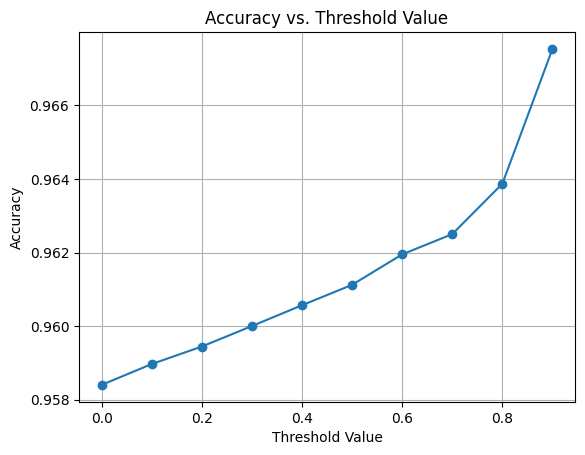

In [43]:
threshVsAcc_is(model=cnn_cross)

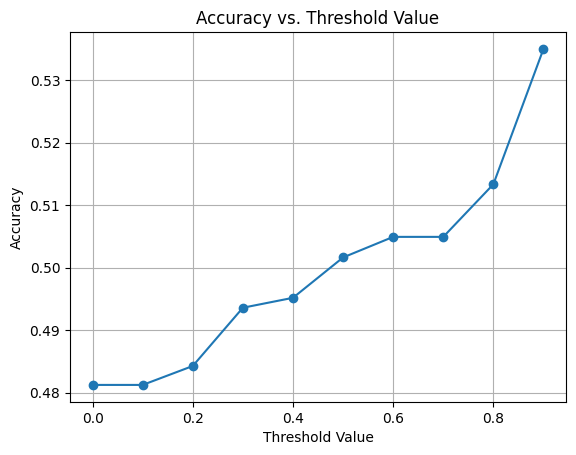

In [123]:
acc_dic['cnn_cross'] = threshVsAcc_oos(model=cnn_cross)

## CNN with Brier loss

In [53]:
cnn_brier = CNN().to(device)
loss_fn = MyBrier
optimizer = torch.optim.SGD(cnn_brier.parameters(), lr=0.001, momentum=0.9)

In [54]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    cnn_brier.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, model=cnn_brier, optimizer=optimizer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    cnn_brier.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = cnn_brier(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if not os.path.exists('CNN_Brier_score'):
          os.mkdir('CNN_Brier_score')
        model_path = 'CNN_Brier_score/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(cnn_brier.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.5337009043693544
  batch 2000 loss: 0.7843657482042908
  batch 3000 loss: 0.2737855984130874
LOSS train 0.2737855984130874 valid 0.15437188744544983
EPOCH 2:
  batch 1000 loss: 0.14824872676306405
  batch 2000 loss: 0.12260124775255099
  batch 3000 loss: 0.11199003890910535
LOSS train 0.11199003890910535 valid 0.09515275806188583
EPOCH 3:
  batch 1000 loss: 0.08932112012777361
  batch 2000 loss: 0.083398730781395
  batch 3000 loss: 0.07555235286205425
LOSS train 0.07555235286205425 valid 0.06544464081525803
EPOCH 4:
  batch 1000 loss: 0.06560166004050552
  batch 2000 loss: 0.06377016011929663
  batch 3000 loss: 0.0659196780065613
LOSS train 0.0659196780065613 valid 0.05925772711634636
EPOCH 5:
  batch 1000 loss: 0.056540074210577586
  batch 2000 loss: 0.05841943945062303
  batch 3000 loss: 0.05359027470304136
LOSS train 0.05359027470304136 valid 0.04658382758498192


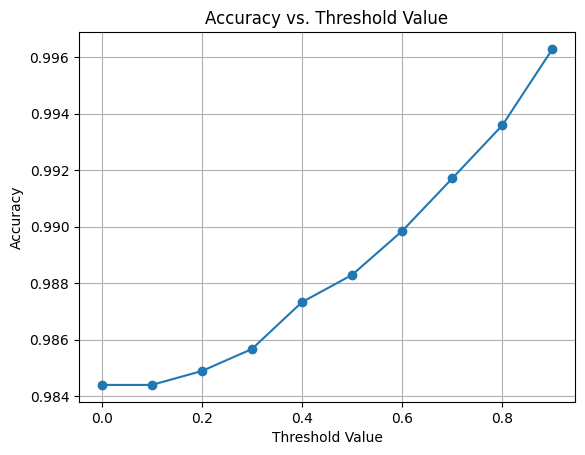

In [55]:
threshVsAcc_is(model=cnn_brier)

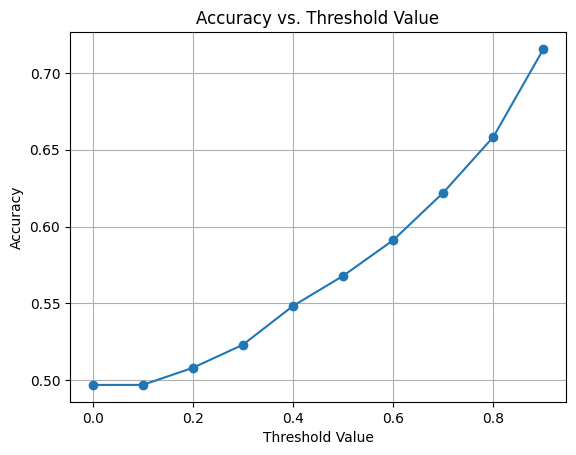

In [124]:
acc_dic['cnn_brier'] = threshVsAcc_oos(model=cnn_brier)

## CNN with Brier loss and adversarial training

In [58]:
cnn_brier_adv = CNN().to(device)
loss_fn = MyBrier
optimizer = torch.optim.SGD(cnn_brier_adv.parameters(), lr=0.001, momentum=0.9)

In [59]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    cnn_brier_adv.train(True)
    avg_loss = train_one_epoch_adv(epoch_number, writer, model=cnn_brier_adv, optimizer=optimizer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    cnn_brier_adv.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = cnn_brier_adv(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if not os.path.exists('CNN_Brier_score_adv'):
          os.mkdir('CNN_Brier_score_adv')
        model_path = 'CNN_Brier_score_adv/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(cnn_brier_adv.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 3.0893950228691103
  batch 2000 loss: 2.5741780116558073
  batch 3000 loss: 1.9365499691963195
LOSS train 1.9365499691963195 valid 0.13334065675735474
EPOCH 2:
  batch 1000 loss: 1.7337056391239167
  batch 2000 loss: 1.7142393482923508
  batch 3000 loss: 1.6881446878910065
LOSS train 1.6881446878910065 valid 0.06424807757139206
EPOCH 3:
  batch 1000 loss: 1.6707572296857833
  batch 2000 loss: 1.6688773444890976
  batch 3000 loss: 1.663196922302246
LOSS train 1.663196922302246 valid 0.05017773061990738
EPOCH 4:
  batch 1000 loss: 1.652334902048111
  batch 2000 loss: 1.6530143175125123
  batch 3000 loss: 1.64866832447052
LOSS train 1.64866832447052 valid 0.04113910347223282
EPOCH 5:
  batch 1000 loss: 1.639197048664093
  batch 2000 loss: 1.643315238714218
  batch 3000 loss: 1.6424354003667831
LOSS train 1.6424354003667831 valid 0.03936496749520302


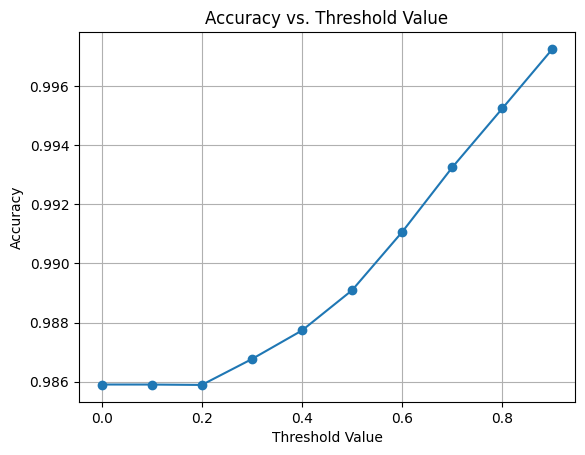

In [62]:
threshVsAcc_is(model=cnn_brier_adv)

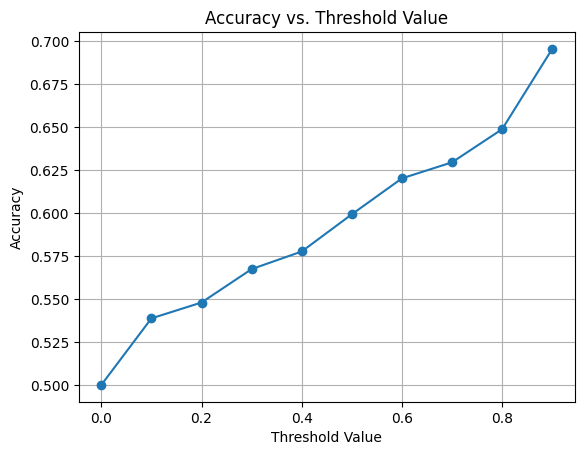

In [125]:
acc_dic['cnn_brier_adv'] = threshVsAcc_oos(model=cnn_brier_adv)

## Ensemble of 5 CNNs with Brier loss

In [66]:
m1 = CNN().to(device)
m2 = CNN().to(device)
m3 = CNN().to(device)
m4 = CNN().to(device)
m5 = CNN().to(device)
M = [m1, m2, m3, m4, m5]
loss_fn = MyBrier
optimizer1 = torch.optim.SGD(m1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.SGD(m2.parameters(), lr=0.001, momentum=0.9)
optimizer3 = torch.optim.SGD(m3.parameters(), lr=0.001, momentum=0.9)
optimizer4 = torch.optim.SGD(m4.parameters(), lr=0.001, momentum=0.9)
optimizer5 = torch.optim.SGD(m5.parameters(), lr=0.001, momentum=0.9)
opts = [optimizer1,
        optimizer2,
        optimizer3,
        optimizer4,
        optimizer5]

In [67]:
for ind, m in enumerate(M):
    # Initializing in a separate cell so we can easily add more epochs to the same run
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
  epoch_number = 0

  EPOCHS = 5

  best_vloss = 1_000_000.

  for epoch in range(EPOCHS):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      m.train(True)
      avg_loss = train_one_epoch(epoch_number, writer, model=m, optimizer=opts[ind])


      running_vloss = 0.0
      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      m.eval()

      # Disable gradient computation and reduce memory consumption.
      with torch.no_grad():
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              voutputs = m(vinputs)
              vloss = loss_fn(voutputs, vlabels)
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()
      # Track best performance, and save the model's state
      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          if not os.path.exists('CNN_Brier_ens_5'):
            os.mkdir('CNN_Brier_ens_5')
          model_path = 'CNN_Brier_ens_5/' + str(ind) + 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(m.state_dict(), model_path)

      epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.5297686505317687
  batch 2000 loss: 1.085775497674942
  batch 3000 loss: 0.3084935499597341
LOSS train 0.3084935499597341 valid 0.16523516178131104
EPOCH 2:
  batch 1000 loss: 0.15761446073488333
  batch 2000 loss: 0.1285493517026771
  batch 3000 loss: 0.11296135213132948
LOSS train 0.11296135213132948 valid 0.08531393110752106
EPOCH 3:
  batch 1000 loss: 0.09097088119952242
  batch 2000 loss: 0.08216660695831524
  batch 3000 loss: 0.08007998574558588
LOSS train 0.08007998574558588 valid 0.0650111585855484
EPOCH 4:
  batch 1000 loss: 0.06909709903841577
  batch 2000 loss: 0.06683681389011326
  batch 3000 loss: 0.06521987300028559
LOSS train 0.06521987300028559 valid 0.060842566192150116
EPOCH 5:
  batch 1000 loss: 0.05769538948211266
  batch 2000 loss: 0.055531472384631346
  batch 3000 loss: 0.05207904834880173
LOSS train 0.05207904834880173 valid 0.05134286358952522
EPOCH 1:
  batch 1000 loss: 1.515583592772484
  batch 2000 loss: 1.1180019579529763
  batc

In [71]:
def ens_5(input):
  return ensemble(M, input)

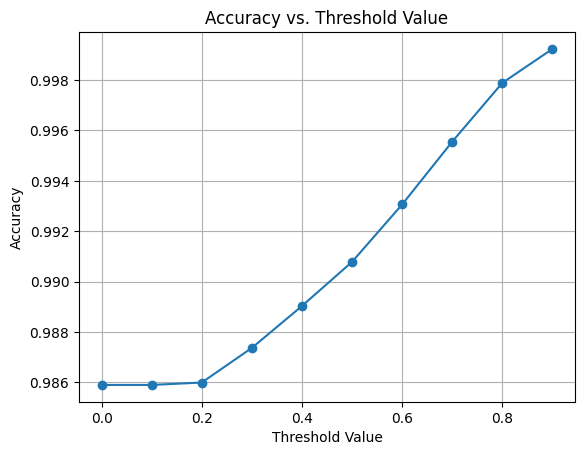

In [72]:
threshVsAcc_is(model=ens_5)

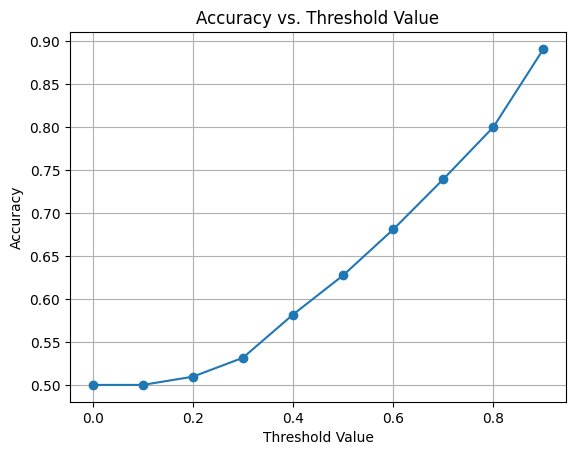

In [126]:
acc_dic['ens_5'] = threshVsAcc_oos(model=ens_5)

## Ensemble of 5 CNNs with Brier loss and adversarial training

In [104]:
m1_adv = CNN().to(device)
m2_adv = CNN().to(device)
m3_adv = CNN().to(device)
m4_adv = CNN().to(device)
m5_adv = CNN().to(device)
M_adv = [m1_adv, m2_adv, m3_adv, m4_adv, m5_adv]
loss_fn = MyBrier
optimizer1 = torch.optim.SGD(m1_adv.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.SGD(m2_adv.parameters(), lr=0.001, momentum=0.9)
optimizer3 = torch.optim.SGD(m3_adv.parameters(), lr=0.001, momentum=0.9)
optimizer4 = torch.optim.SGD(m4_adv.parameters(), lr=0.001, momentum=0.9)
optimizer5 = torch.optim.SGD(m5_adv.parameters(), lr=0.001, momentum=0.9)
opts = [optimizer1,
        optimizer2,
        optimizer3,
        optimizer4,
        optimizer5]

In [105]:
for ind, m in enumerate(M_adv):
    # Initializing in a separate cell so we can easily add more epochs to the same run
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
  epoch_number = 0

  EPOCHS = 5

  best_vloss = 1_000_000.

  for epoch in range(EPOCHS):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      m.train(True)
      avg_loss = train_one_epoch_adv(epoch_number, writer, model=m, optimizer=opts[ind])


      running_vloss = 0.0
      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      m.eval()

      # Disable gradient computation and reduce memory consumption.
      with torch.no_grad():
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              voutputs = m(vinputs)
              vloss = loss_fn(voutputs, vlabels)
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()
      # Track best performance, and save the model's state
      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          if not os.path.exists('CNN_Brier_ens_5_adv'):
            os.mkdir('CNN_Brier_ens_5_adv')
          model_path = 'CNN_Brier_ens_5_adv/' + str(ind) + 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(m.state_dict(), model_path)

      epoch_number += 1

EPOCH 1:
  batch 1000 loss: 3.0420840611457827
  batch 2000 loss: 2.045709511756897
  batch 3000 loss: 1.750311069726944
LOSS train 1.750311069726944 valid 0.08649854362010956
EPOCH 2:
  batch 1000 loss: 1.7035249063968658
  batch 2000 loss: 1.6833125721216202
  batch 3000 loss: 1.6723676608800888
LOSS train 1.6723676608800888 valid 0.058790422976017
EPOCH 3:
  batch 1000 loss: 1.6605460594892503
  batch 2000 loss: 1.6622650302648545
  batch 3000 loss: 1.6544435160160065
LOSS train 1.6544435160160065 valid 0.05500194802880287
EPOCH 4:
  batch 1000 loss: 1.6528830555677414
  batch 2000 loss: 1.6418820943832397
  batch 3000 loss: 1.648651734828949
LOSS train 1.648651734828949 valid 0.04210207238793373
EPOCH 5:
  batch 1000 loss: 1.6405847806930542
  batch 2000 loss: 1.6393203399181366
  batch 3000 loss: 1.6399276394844056
LOSS train 1.6399276394844056 valid 0.03367951512336731
EPOCH 1:
  batch 1000 loss: 3.0705883002281187
  batch 2000 loss: 2.2317228416204453
  batch 3000 loss: 1.775806

In [106]:
def ens_5_adv(input):
  return ensemble(M_adv, input)

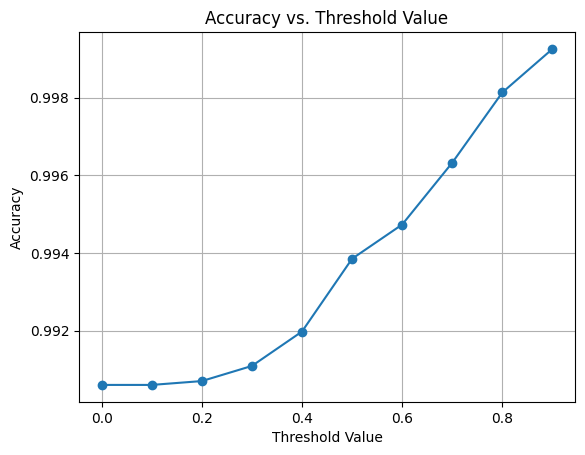

In [107]:
threshVsAcc_is(model=ens_5_adv)

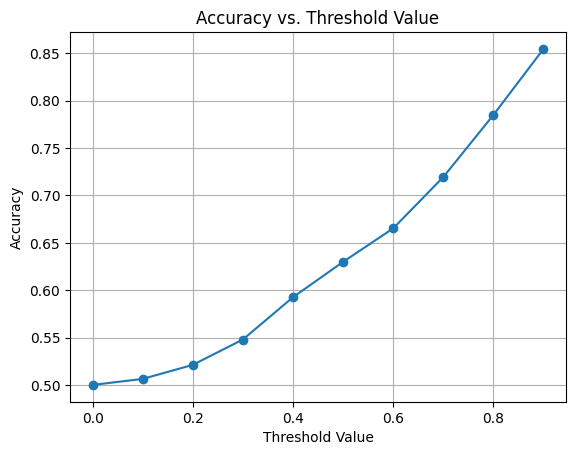

In [127]:
acc_dic['ens_5_adv'] = threshVsAcc_oos(model=ens_5_adv)

## CNN with MC-dropout and cross-entropy loss

In [114]:
class CNNClassifierWithMCDropout(nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(CNNClassifierWithMCDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))
        return x

In [115]:
mc_cnn = CNNClassifierWithMCDropout().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mc_cnn.parameters(), lr=0.001, momentum=0.9)

In [116]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    mc_cnn.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, model=mc_cnn, optimizer=optimizer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    mc_cnn.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            vlabels.to(device)
            voutputs = mc_cnn(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        if not os.path.exists('mc_cnn'):
            os.mkdir('mc_cnn')
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(mc_cnn.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.300995557785034
  batch 2000 loss: 2.29202704167366
  batch 3000 loss: 2.20095390021801
LOSS train 2.20095390021801 valid 1.71529221534729
EPOCH 2:
  batch 1000 loss: 1.721198786854744
  batch 2000 loss: 1.66545949113369
  batch 3000 loss: 1.6322294661998749
LOSS train 1.6322294661998749 valid 1.5681183338165283
EPOCH 3:
  batch 1000 loss: 1.6042407050132752
  batch 2000 loss: 1.5852807511091231
  batch 3000 loss: 1.5715221576690674
LOSS train 1.5715221576690674 valid 1.528610110282898
EPOCH 4:
  batch 1000 loss: 1.5555104019641877
  batch 2000 loss: 1.5476954959630966
  batch 3000 loss: 1.5484211906194687
LOSS train 1.5484211906194687 valid 1.512844443321228
EPOCH 5:
  batch 1000 loss: 1.537261988043785
  batch 2000 loss: 1.5334490152597426
  batch 3000 loss: 1.5299012888669967
LOSS train 1.5299012888669967 valid 1.5017919540405273


In [120]:
def activate_dropout(m):
        if isinstance(m, nn.Dropout):
            m.train()



def mc_dropout_inference(inputs, num_samples=10):

    mc_cnn.apply(activate_dropout)
    mc_cnn.eval()

    outputs = torch.stack([mc_cnn(inputs) for _ in range(num_samples)])
    mean_output = outputs.mean(dim=0)
    return mean_output


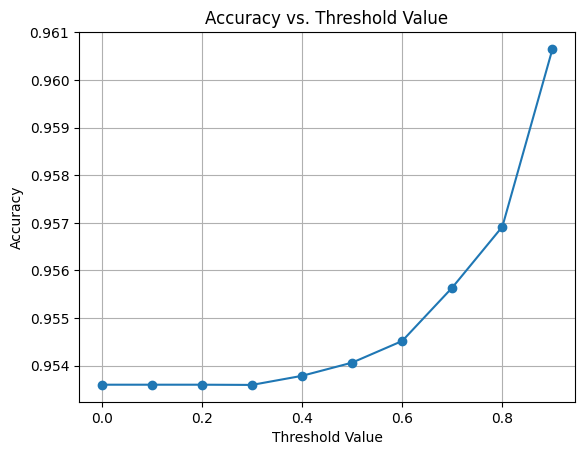

[0.9536,
 0.9536,
 0.9536,
 0.9535953595359536,
 0.9537861358407522,
 0.9540632506004804,
 0.9545181326387497,
 0.9556403050983541,
 0.9569199798691495,
 0.960653077781158]

In [133]:
threshVsAcc_is(model=mc_dropout_inference)

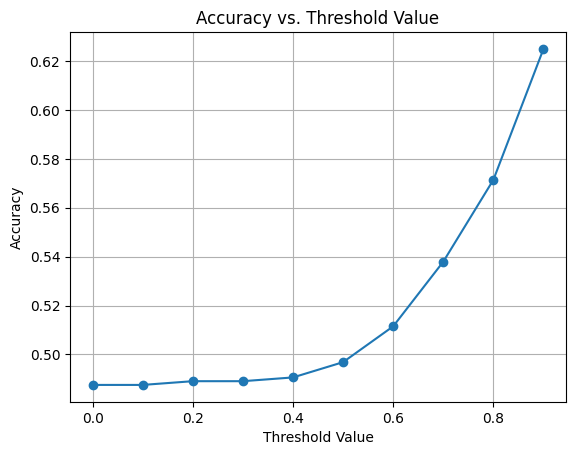

In [128]:
acc_dic['mc_dropout'] = threshVsAcc_oos(model=mc_dropout_inference)

# Final Graph

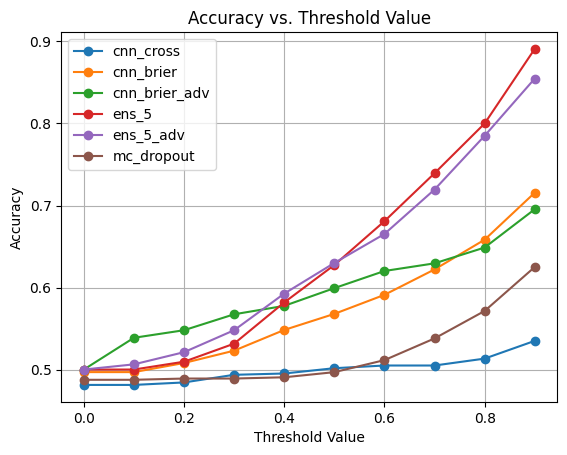

In [132]:
threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for name in acc_dic:
  acc = acc_dic[name]
  plt.plot(threshold_values, acc, marker='o', label=name)
plt.xlabel('Threshold Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Value')
plt.grid(True)
plt.legend()
# plt.savefig('final_fixed.png')
plt.show()

# Scratch

In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 10)

    def forward(self, x):
        x = x = x.view(-1, 28*28).to(device)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

In [ ]:
d = {
    'nn_cross': [torch.nn.CrossEntropyLoss(), train_one_epoch],
    'nn_brier': [MyBrier, train_one_epoch],
    'nn_brier_adv': [MyBrier, train_one_epoch_adv]
}
mods = {}

In [ ]:
for name in d:
  mods[name] = NN().to(device)
  loss_fn = d[name][0]
  train_ep = d[name][1]
  optimizer = torch.optim.SGD(mods[name].parameters(), lr=0.001, momentum=0.9)
  # Initializing in a separate cell so we can easily add more epochs to the same run
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
  epoch_number = 0

  EPOCHS = 5

  best_vloss = 1_000_000.

  for epoch in range(EPOCHS):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      mods[name].train(True)
      avg_loss = train_ep(epoch_number, writer, model=mods[name], optimizer=optimizer)


      running_vloss = 0.0
      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      mods[name].eval()

      # Disable gradient computation and reduce memory consumption.
      with torch.no_grad():
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              voutputs = mods[name](vinputs)
              vloss = loss_fn(voutputs, vlabels)
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()

      # Track best performance, and save the model's state
      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          if not os.path.exists('NN_' + name):
            os.mkdir('NN_' + name)
          model_path = 'NN_' + name + '/model_{}_{}'.format(timestamp, epoch_number)
          torch.save(mods[name].state_dict(), model_path)

      epoch_number += 1

In [ ]:
threshVsAcc_is(model=mods['nn_cross'])

In [ ]:
threshVsAcc_oos(model=mods['nn_cross'])

In [ ]:
threshVsAcc_is(model=mods['nn_brier'])

In [ ]:
threshVsAcc_oos(model=mods['nn_brier'])

In [ ]:
threshVsAcc_is(model=mods['nn_brier_adv'])

In [ ]:
threshVsAcc_oos(model=mods['nn_brier_adv'])

In [ ]:
m1_nn = NN().to(device)
m2_nn = NN().to(device)
m3_nn = NN().to(device)
m4_nn = NN().to(device)
m5_nn = NN().to(device)
M_nn = [m1_nn, m2_nn, m3_nn, m4_nn, m5_nn]
loss_fn = MyBrier
optimizer1 = torch.optim.SGD(m1_nn.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.SGD(m2_nn.parameters(), lr=0.001, momentum=0.9)
optimizer3 = torch.optim.SGD(m3_nn.parameters(), lr=0.001, momentum=0.9)
optimizer4 = torch.optim.SGD(m4_nn.parameters(), lr=0.001, momentum=0.9)
optimizer5 = torch.optim.SGD(m5_nn.parameters(), lr=0.001, momentum=0.9)
opts = [optimizer1,
        optimizer2,
        optimizer3,
        optimizer4,
        optimizer5]

In [ ]:
for ind, m in enumerate(M_nn):
    # Initializing in a separate cell so we can easily add more epochs to the same run
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
  epoch_number = 0

  EPOCHS = 5

  best_vloss = 1_000_000.

  for epoch in range(EPOCHS):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      m.train(True)
      avg_loss = train_one_epoch(epoch_number, writer, model=m, optimizer=opts[ind])


      running_vloss = 0.0
      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      m.eval()

      # Disable gradient computation and reduce memory consumption.
      with torch.no_grad():
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              voutputs = m(vinputs)
              vloss = loss_fn(voutputs, vlabels)
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()
      # Track best performance, and save the model's state
      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          if not os.path.exists('NN_Brier_ens_5'):
            os.mkdir('NN_Brier_ens_5')
          model_path = 'NN_Brier_ens_5/' + str(ind) + 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(m.state_dict(), model_path)

      epoch_number += 1

In [ ]:
def ens_5_nn(input):
  return ensemble(M_nn, input)

In [ ]:
threshVsAcc_is(model=ens_5_nn)

In [ ]:
threshVsAcc_oos(model=ens_5_nn)

In [ ]:
m1_nn_adv = NN().to(device)
m2_nn_adv = NN().to(device)
m3_nn_adv = NN().to(device)
m4_nn_adv = NN().to(device)
m5_nn_adv = NN().to(device)
M_nn_adv = [m1_nn_adv, m2_nn_adv, m3_nn_adv, m4_nn_adv, m5_nn_adv]
loss_fn = MyBrier
optimizer1 = torch.optim.SGD(m1_nn_adv.parameters(), lr=0.001, momentum=0.9)
optimizer2 = torch.optim.SGD(m2_nn_adv.parameters(), lr=0.001, momentum=0.9)
optimizer3 = torch.optim.SGD(m3_nn_adv.parameters(), lr=0.001, momentum=0.9)
optimizer4 = torch.optim.SGD(m4_nn_adv.parameters(), lr=0.001, momentum=0.9)
optimizer5 = torch.optim.SGD(m5_nn_adv.parameters(), lr=0.001, momentum=0.9)
opts = [optimizer1,
        optimizer2,
        optimizer3,
        optimizer4,
        optimizer5]

In [ ]:
for ind, m in enumerate(M_nn_adv):
    # Initializing in a separate cell so we can easily add more epochs to the same run
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('runs/mnist_{}'.format(timestamp))
  epoch_number = 0

  EPOCHS = 5

  best_vloss = 1_000_000.

  for epoch in range(EPOCHS):
      print('EPOCH {}:'.format(epoch_number + 1))

      # Make sure gradient tracking is on, and do a pass over the data
      m.train(True)
      avg_loss = train_one_epoch_adv(epoch_number, writer, model=m, optimizer=opts[ind])


      running_vloss = 0.0
      # Set the model to evaluation mode, disabling dropout and using population
      # statistics for batch normalization.
      m.eval()

      # Disable gradient computation and reduce memory consumption.
      with torch.no_grad():
          for i, vdata in enumerate(validation_loader):
              vinputs, vlabels = vdata
              voutputs = m(vinputs)
              vloss = loss_fn(voutputs, vlabels)
              running_vloss += vloss

      avg_vloss = running_vloss / (i + 1)
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

      # Log the running loss averaged per batch
      # for both training and validation
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.flush()
      # Track best performance, and save the model's state
      if avg_vloss < best_vloss:
          best_vloss = avg_vloss
          if not os.path.exists('NN_Brier_ens_5_adv'):
            os.mkdir('NN_Brier_ens_5_adv')
          model_path = 'NN_Brier_ens_5_adv/' + str(ind) + 'model_{}_{}'.format(timestamp, epoch_number)
          torch.save(m.state_dict(), model_path)

      epoch_number += 1

In [ ]:
def ens_5_nn_adv(input):
  return ensemble(M_nn_adv, input)

In [ ]:
threshVsAcc_is(model=ens_5_nn_adv)

In [ ]:
threshVsAcc_oos(model=ens_5_nn_adv)

In [ ]:
class MonteCarloDropoutNet(nn.Module):
    def __init__(self):
        super(MonteCarloDropoutNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.bn1 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.bn2 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.bn3 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 10)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [ ]:
train_loader = training_loader
test_loader = validation_loader

# Model and optimizer
mc_drop = MonteCarloDropoutNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):
    mc_drop.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = mc_drop(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def mc_dropout_inference(model, data, T=100):
    model.train()  # Ensure dropout is "on"
    predictions = [F.softmax(model(data), dim=1) for _ in range(T)]
    return torch.stack(predictions)

In [ ]:
def mc_inf(inputs):
  return mc_dropout_inference(mc_drop, inputs)

In [ ]:
threshVsAcc_is(model=mc_inf)

In [ ]:
threshVsAcc_oos(model=mc_inf)

In [ ]:
threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for name in acc_dic_CNN:
  acc = acc_dic_CNN[name]
  plt.plot(threshold_values, acc, marker='o', label='name')
plt.xlabel('Threshold Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Value')
plt.grid(True)
plt.legend
plt.show()

In [ ]:
threshold_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for name in acc_dic_NN:
  acc = acc_dic_NN[name]
  plt.plot(threshold_values, acc, marker='o', label='name')
plt.xlabel('Threshold Value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold Value')
plt.grid(True)
plt.legend
plt.show()